# 1. Initializing the workspace for the data preparation. I will use pyspark for this task.

In [1]:
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['JAVA_HOME'] = '/opt/homebrew/opt/openjdk@17' 

In [2]:
from pyspark.sql import SparkSession, types, functions
import pyspark.pandas as ps
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import het_arch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

/Users/yusufsurmen/Currency-Forecast-Webpage/.venv/lib/python3.13/site-packages/pyspark/pandas/__init__.py:43: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


#### 2. We need to start a sparksession in order to use pyspark.

In [3]:
spark = SparkSession.builder \
    .appName("data_cleaning_and_exploration") \
    .config("spark.python.worker.reuse", "true") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/25 00:12:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### 3. creating two functions to read all the files 

In [ ]:
#path is set to current working directory.
local_path = os.getcwd()
print(f"Working directory: {local_path}")

#files are located on the same folder so simplifying access with just getting the relative path
def relative_path_getter(local_path):
    """
    This is a function for the getting relative path of the csv files so that they can be extracted easily.
    It is basically automating the data extraction and reading process.
    
    Parameters:
        local_path: str
            it is a string of the full local path of where the files are stored
    Returns:
            csv_files: str
            returns path of the csv files only. Which are our data in this case.
    """
    csv_files = [f for f in os.listdir(local_path) if f.endswith(".csv") and os.path.isfile(os.path.join(local_path, f))]
    return csv_files
def df_creator(csv_files=None, local_path=""):
    """
    This function takes the csv file paths from the relative_path_getter function and then creates spark dataframes and stores them in dictionary
    where dictionary formatted as filename without its csv extension and spark dataframe is the value

    Parameters:
        csv_files: csv file paths
        local_path: base path of the project folder
    Returns:
        file_store: Dictionary containing spark dataframes for each of the currencies
    """
    if csv_files == None:
        return f"there is no file to process for dataframe creation"
    file_store = {}
    #it is preferrably faster when you know what to typecast your columns though you need to investigate your csv file carefully and when the
    #number of the features increase it can be hard to do so but inferschema is also slow and not gonna work efficiently when you have such big data
    schema = types.StructType([
        types.StructField("Time", types.TimestampType(), True),
        types.StructField("Open", types.DoubleType(), True),
        types.StructField("High", types.DoubleType(), True),
        types.StructField("Low", types.DoubleType(), True),
        types.StructField("Close", types.DoubleType(), True),
        types.StructField("Volume", types.IntegerType(), True)
    ])
    for file in csv_files:
        file_name = os.path.splitext(file)[0]
        file_path = os.path.join(local_path, file)
        file_store[file_name] = spark.read.csv(file_path, header=True ,schema=schema, sep="\t")
    return file_store
csv_file_names = relative_path_getter(local_path)
dfs = df_creator(csv_file_names, local_path)
#data gathering and creating dfs are automated and multiple dfs are created and stored in a dict. I do not know if it is a efficient approach.
dfs

Working directory: /Users/yusufsurmen/Currency-Forecast-Webpage


{'GBPUSD_M1': DataFrame[Time: timestamp, Open: double, High: double, Low: double, Close: double, Volume: int],
 'USDCHF_M1': DataFrame[Time: timestamp, Open: double, High: double, Low: double, Close: double, Volume: int],
 'USDCAD_M1': DataFrame[Time: timestamp, Open: double, High: double, Low: double, Close: double, Volume: int],
 'EURUSD_M1': DataFrame[Time: timestamp, Open: double, High: double, Low: double, Close: double, Volume: int]}

#### 4. Data exploration and Analysis

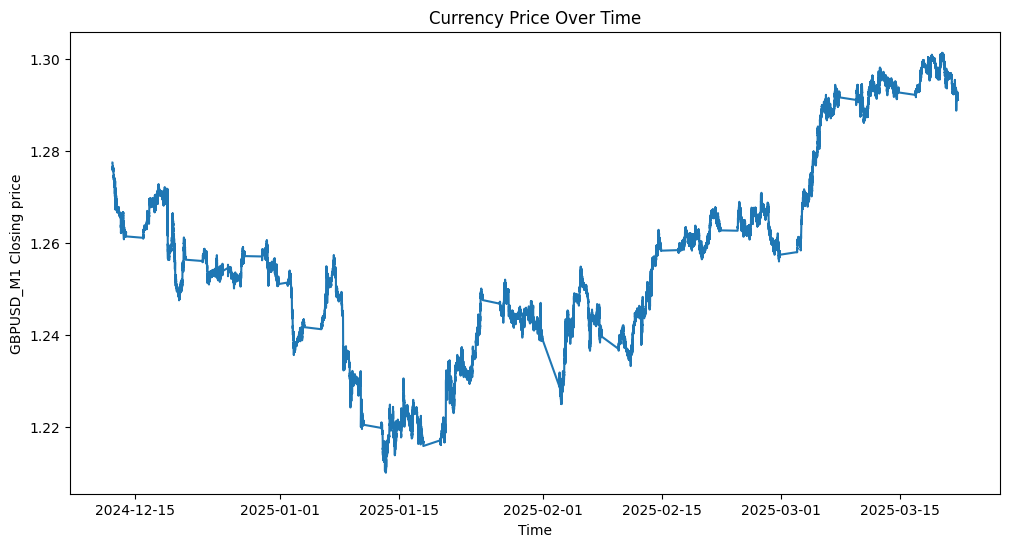

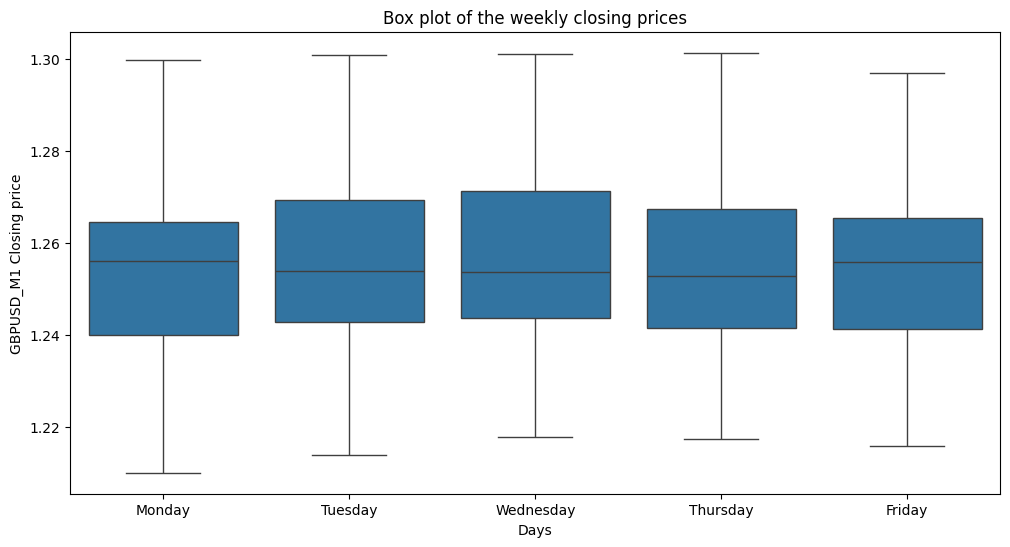

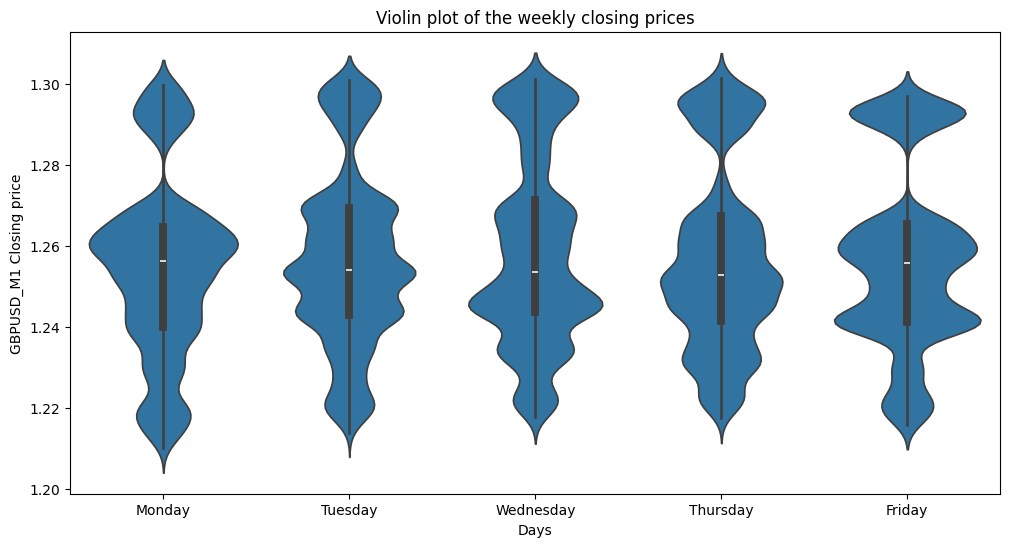

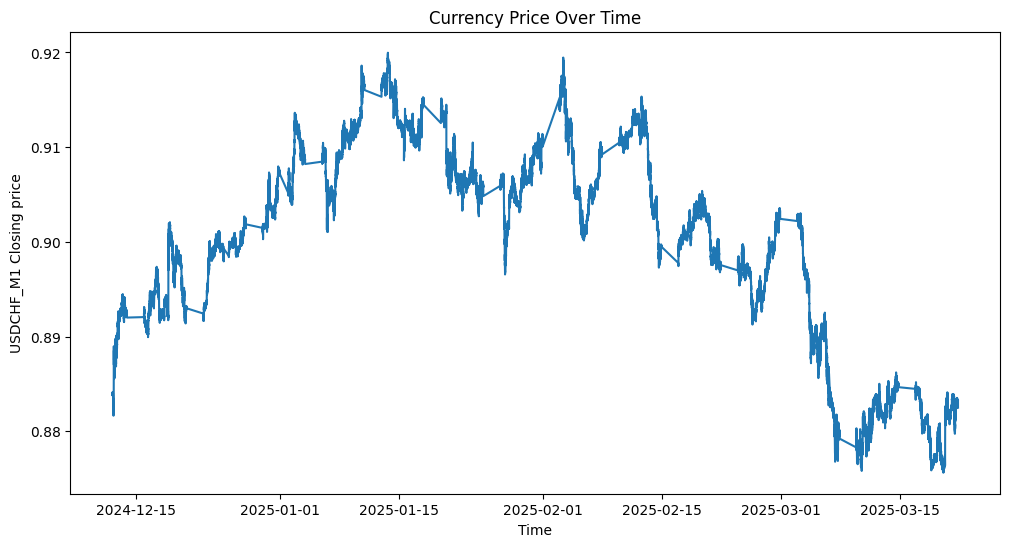

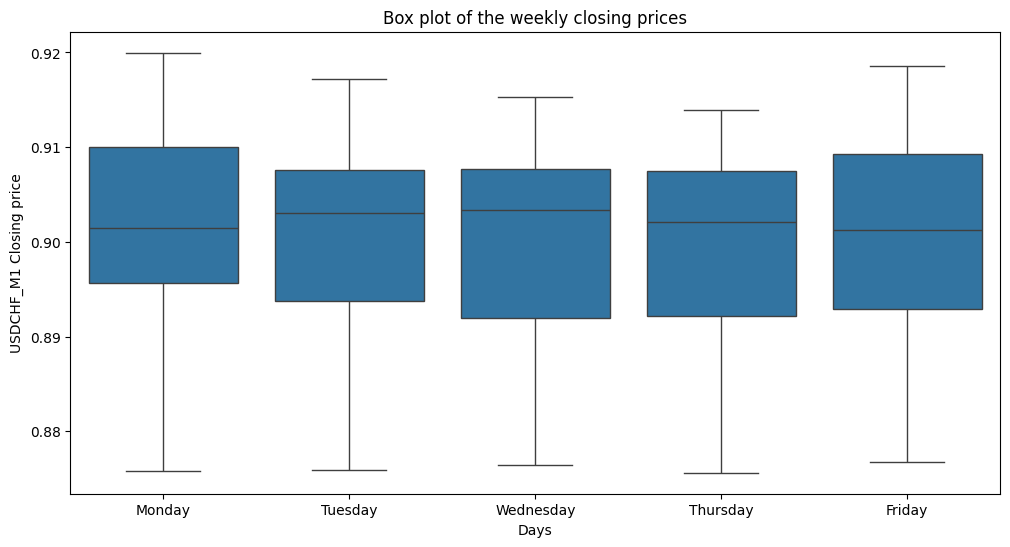

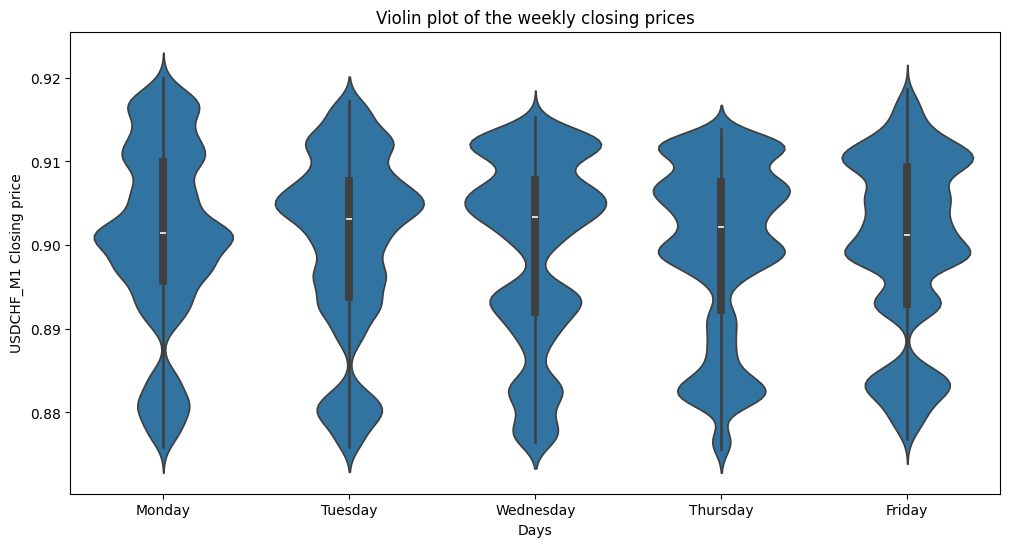

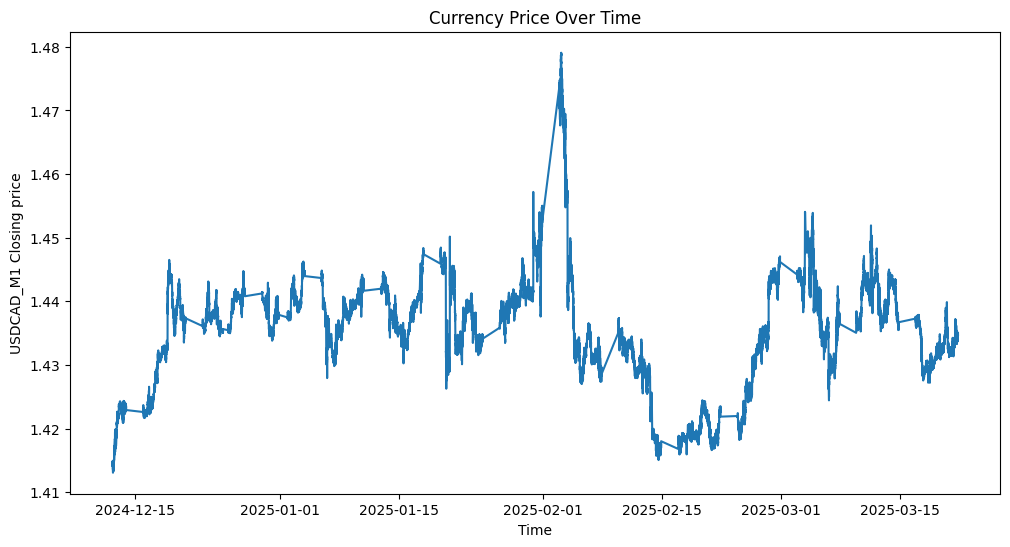

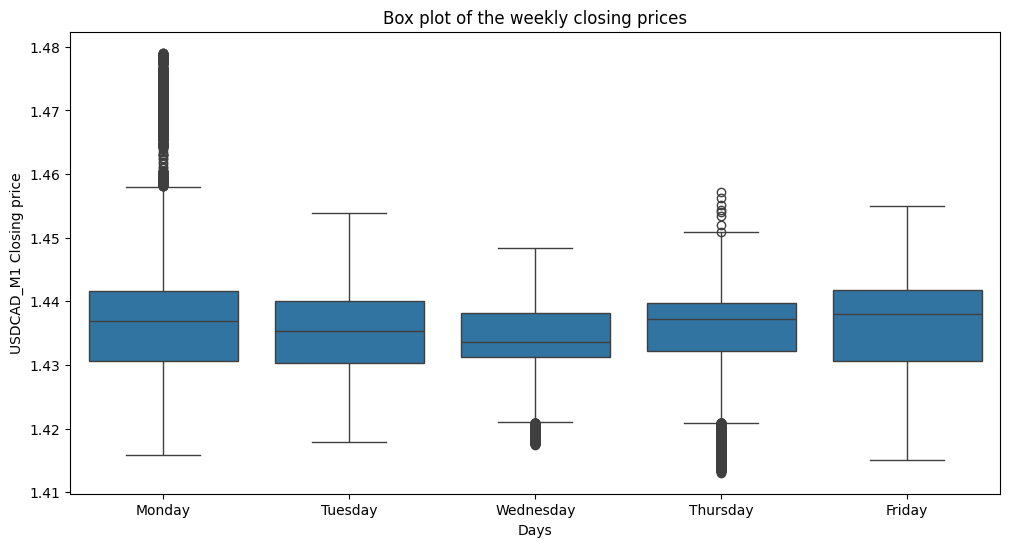

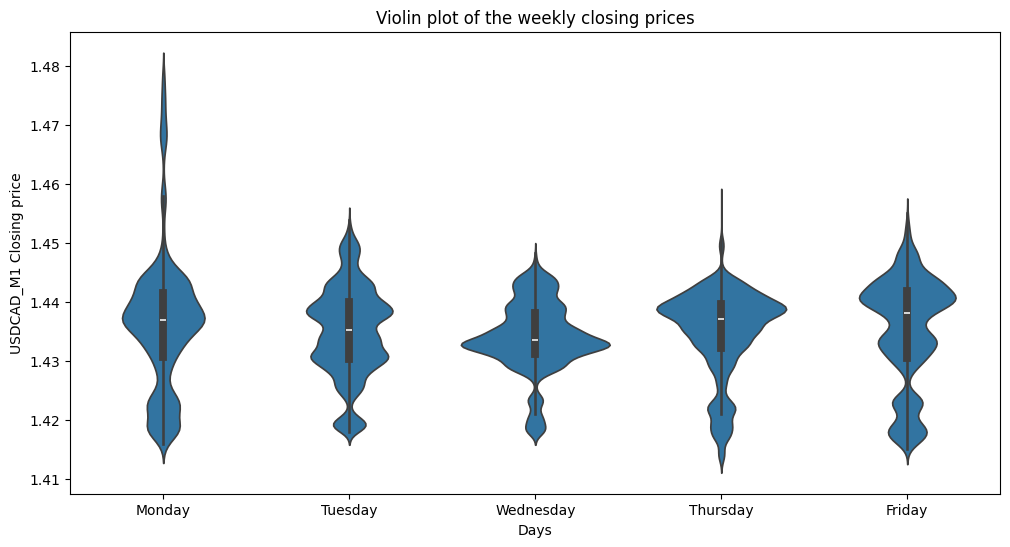

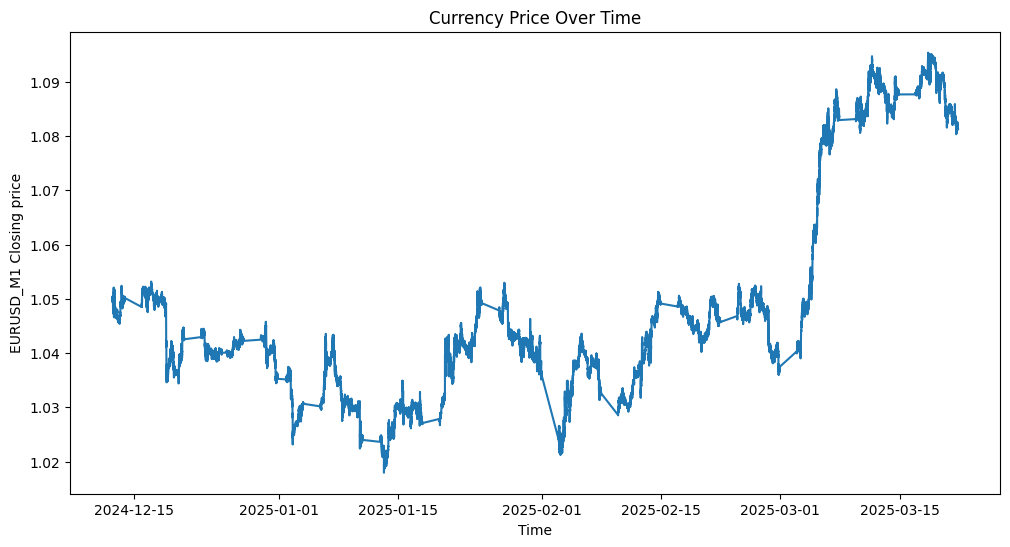

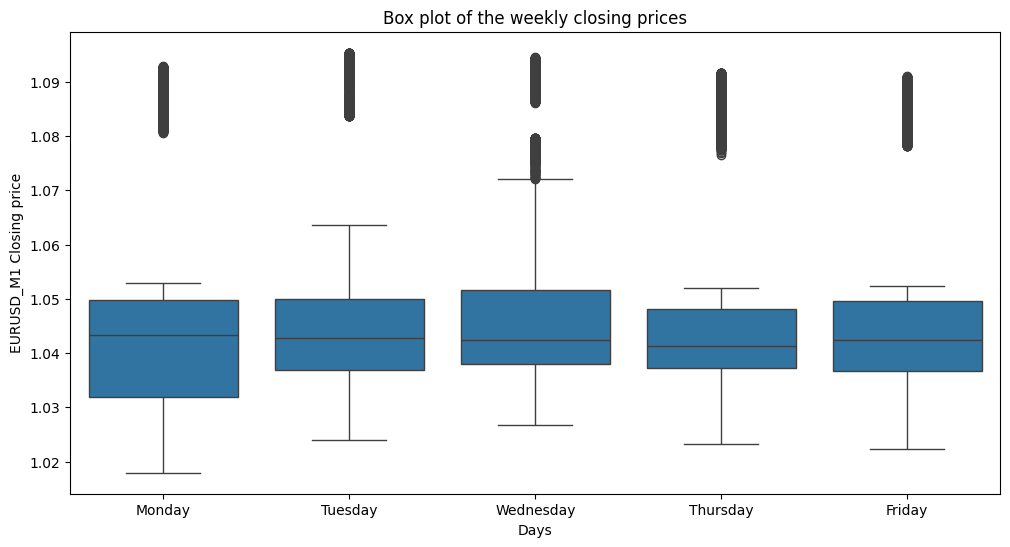

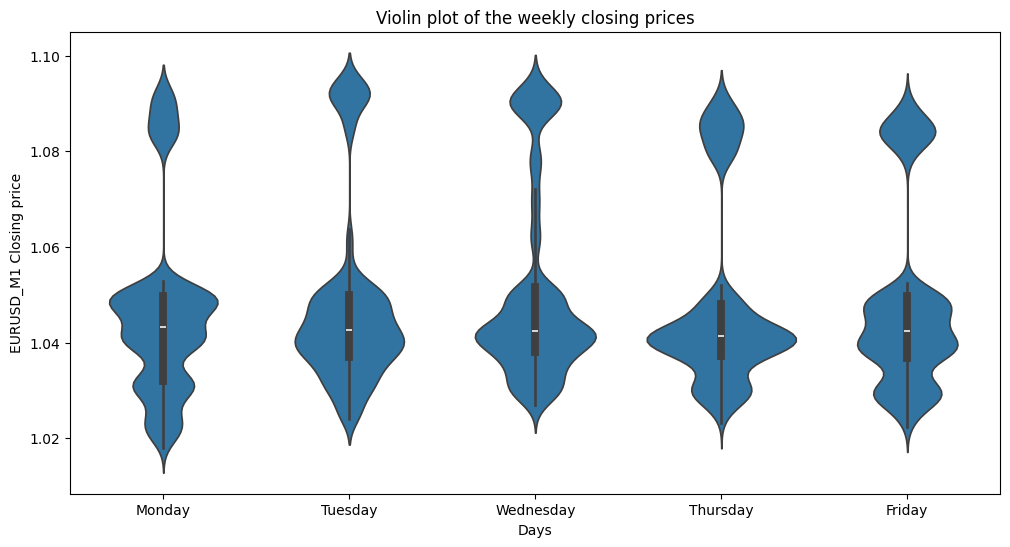

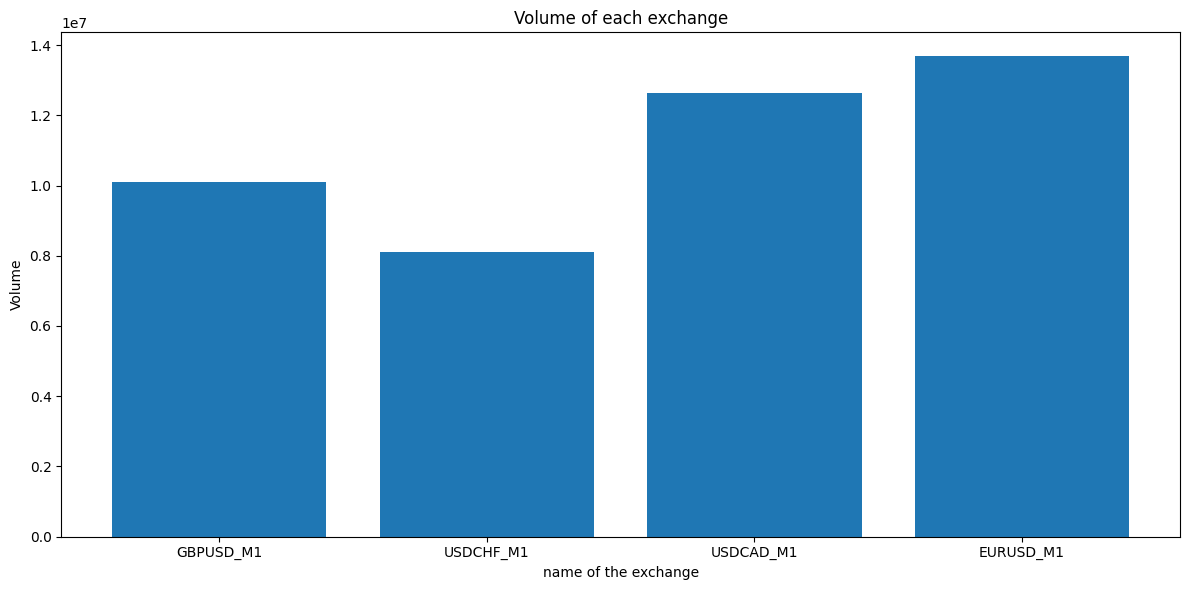

In [6]:
def visualizer(dfs):
    """
    This is a function for visualizing the dataframes and spot the extreme values and the trends of the currencies.

    Parameters:
        dfs: dictionary that is containing currency dataframes as values.
    Returns:
        It does not returns any val but plots the many graphs that gives different information about the currencies.
    """
    total_vol_list = []
    currency_names = []
    for file, df in dfs.items():
        rows = df.count()
        #we are making sure that we do not visualize very big data as it will be very time consuming and unnecessary.
        if rows >= 1000000:
            pandas_df = df.toPandas()
            pandas_df = pandas_df.sample(frac=0.1, random_state=1)
        else:
            pandas_df = df.toPandas()

        total_vol = pandas_df["Volume"].sum()
        total_vol_list.append(total_vol)
        currency_names.append(file)
        
        ## lineplot to see price changes over time
        plt.figure(figsize=(12,6))
        sns.lineplot(data=pandas_df, x="Time", y="Close", legend=True)
        plt.title("Currency Price Over Time")
        plt.xlabel("Time")
        plt.ylabel(f"{file} Closing price")
        plt.show()

        # extracting day from the time col so that we can plot daily prices.
        pandas_df["Day"] = pandas_df["Time"].dt.day_name()

        # box plot on weekly close prices
        plt.figure(figsize=(12,6))
        sns.boxplot(data=pandas_df, x="Day", y="Close", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])
        plt.title("Box plot of the weekly closing prices")
        plt.xlabel("Days")
        plt.ylabel(f"{file} Closing price")
        plt.show()

        #violin plot on weekly close prices
        plt.figure(figsize=(12,6))
        sns.violinplot(data=pandas_df, x="Day", y="Close", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])
        plt.title("Violin plot of the weekly closing prices")
        plt.xlabel("Days")
        plt.ylabel(f"{file} Closing price")
        plt.show()

    plt.figure(figsize=(12, 6))
    plt.bar(currency_names, total_vol_list)
    plt.title("Volume of each exchange")
    plt.xlabel("name of the exchange")
    plt.ylabel("Volume")
    plt.tight_layout()
    plt.show()

visualizer(dfs)

I observed lots of extreme values in some of the datasets and they should be removed from the dataset for better model training.

### Data Cleaning: it is necessary to clean the data since most of the models either cant work or give bad accuracy with bad data.

In [7]:
# it turns out that pyspark is not directly suited for the use of the classical visualization so we need to convert the data to pandas which I did above haha.
# or skip the steps and directly do the cleaning on the data. or clean and prepare it then visualize it by creating pandas df copys of it.
# which means we are going to do data cleaning first and then do visualizing later on and I think it is not possible to do feature engineering since there are already few columns and tasks is clear.
# now it seems that there are many outliers there from the boxplots of the currencies which means they need to be cleaned in order to have a better model prediction.
def cleaner(files:dict) -> dict:
    """
    It is a function that does the initial cleaning for the data where it handles the NA's in the data and fills them with the mean.

    Parameters:
        files: dictionary containing dataframes
    Returns:
        files: cleaned dataframes
    """
    for name, file in files.items():
        print(f"Processing {name} for data cleaning...")
        file = file.dropDuplicates()
        # I will fill nas with mean values here.
        mean_vals = {}
        # since spark does not have direct imputing like pandas we need to do a bit of longer imputing when we want to go for anything other than dropping NA's
        for col_name in file.columns:
            if col_name != 'Time': 
                try:
                    mean_vals[col_name] = file.select(functions.mean(col_name)).first()[0]
                except Exception as e:
                    print(f"col is not in int/float form")
        file = file.fillna(mean_vals)
        files[name] = file
        #removing inconsistent rows where high is lower than low
        file = file.filter(file["Low"] <= file["High"])
        files[name] = file
        print("\n\n")
    return files
# Now time to add a feature engineering function so that we can create new features and train even greater model !!
def extreme_value_remover(files: dict) -> dict:
    """
    It is a function that does the outlier removal from the data and shows how much of the data was outliers.

    Parameters:
        files: dictionary containing dataframes.
    Returns:
        cleaned_files: dict containing outliers removed data frames.
    """
    cleaned_files = {}
    for name, df in files.items():
        
        print(f"Processing {name} for outlier removal...")
        stats = {}
        for col_name in ['Open', 'High','Low', 'Close', 'Volume']:
            percentiles = df.selectExpr(
                f"percentile_approx({col_name}, array(0.25, 0.5, 0.75), 10000) as percentiles"
            ).collect()[0][0]

            q1 = percentiles[0]
            q3 = percentiles[2]
            iqr = q3 - q1

            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            stats[col_name] = (lower_bound, upper_bound)

        filtered_df = df
        for col_name, (lower_bound, upper_bound) in stats.items():

            filtered_df = filtered_df.filter(
                (functions.col(col_name) >= lower_bound) &
                (functions.col(col_name) <= upper_bound)
            )
        
        # let's see if it was effective or not
        row_count = df.count()
        new_rows = filtered_df.count()
        print(f"Rows prior filtering were {row_count}, after filtering it is reduced to {new_rows}, difference is {row_count - new_rows}, and it accounts for {((row_count - new_rows)/row_count) * 100:.2f}% of the data")

        cleaned_files[name] = filtered_df

    print("\n\n")

    return cleaned_files
def feature_engineering(clean_files) -> dict:
    """
    This function creates new technical indicators commonly used in forex trading.
    
    Parameters:
        cleaned_files: dictionary containing spark dataframes (already cleaned)
    Returns:
        files: dataframes with additional engineered features
    """
    engineered_files = {}
    for name, file in clean_files.items():
        print(f"Freature engineering process for ")

        pandas_df = file.toPandas()

        # adding moving averages (on 5-period and 20-period) 
        pandas_df['MA5'] = pandas_df["Close"].rolling(window=5).mean()
        pandas_df['MA20'] = pandas_df["Close"].rolling(window=20).mean()

        pandas_df['MA20_std'] = pandas_df['Close'].rolling(window=20).std()
        pandas_df['BB_upper'] = pandas_df['MA20'] + (pandas_df['MA20_std'] * 2)
        pandas_df['BB_lower'] = pandas_df['MA20'] - (pandas_df['MA20_std'] * 2)

        pandas_df['Price_Change'] = pandas_df['Close'].diff()
        pandas_df['Price_Change_Pct'] = pandas_df['Close'].pct_change() * 100

        pandas_df['Daily_Range'] = pandas_df['High'] - pandas_df['Low']
        pandas_df['Daily_Range_Pct'] = ((pandas_df['High'] - pandas_df['Low']) / pandas_df['Low']) * 100

        tr1 = pandas_df['High'] - pandas_df['Low']
        tr2 = abs(pandas_df['High'] - pandas_df['Close'].shift(1)) 
        tr3 = abs(pandas_df['Low'] - pandas_df['Close'].shift(1))
        pandas_df['True_Range'] = pd.concat([tr1,tr2,tr3], axis=1).max(axis=1)
        pandas_df['ATR14'] = pandas_df['True_Range'].rolling(window=14).mean()

        delta = pandas_df['Close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = delta.where(delta < 0, 0)

        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()

        rs = avg_gain/avg_loss
        pandas_df['RSI14'] = 100 - (100 / (1 + rs))

        pandas_df['EMA12'] = pandas_df['Close'].ewm(span=12, adjust=False).mean()
        pandas_df['EMA26'] = pandas_df['Close'].ewm(span=26, adjust=False).mean()
        pandas_df['MACD'] = pandas_df['EMA12'] - pandas_df['EMA26']
        pandas_df['MACD_Signal'] = pandas_df['MACD'].ewm(span=9, adjust=False).mean()
        pandas_df['MACD_Hist'] = pandas_df['MACD'] - pandas_df['MACD_Signal']

        numeric_features = pandas_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
        for col in numeric_features:
            if pandas_df[col].isnull().any():
                pandas_df[col] = pandas_df[col].fillna(pandas_df[col].median())

        engineered_files[name] = spark.createDataFrame(pandas_df)
        print(f"  Added {len(pandas_df.columns) - len(file.columns)} new features to {name}")

    return engineered_files        
# And I think of adding visualization function after doing all the stuff on the data or maybe I should be comparing data prior ??
dfs = cleaner(dfs)
dfs = extreme_value_remover(dfs)
dfs = feature_engineering(dfs)

Processing GBPUSD_M1 for data cleaning...



Processing USDCHF_M1 for data cleaning...



Processing USDCHF_M1 for data cleaning...



Processing USDCAD_M1 for data cleaning...



Processing USDCAD_M1 for data cleaning...



Processing EURUSD_M1 for data cleaning...



Processing EURUSD_M1 for data cleaning...



Processing GBPUSD_M1 for outlier removal...



Processing GBPUSD_M1 for outlier removal...
Rows prior filtering were 100000, after filtering it is reduced to 95481, difference is 4519, and it accounts for 4.52% of the data
Processing USDCHF_M1 for outlier removal...
Rows prior filtering were 100000, after filtering it is reduced to 95481, difference is 4519, and it accounts for 4.52% of the data
Processing USDCHF_M1 for outlier removal...
Rows prior filtering were 100000, after filtering it is reduced to 94239, difference is 5761, and it accounts for 5.76% of the data
Processing USDCAD_M1 for outlier removal...
Rows prior filtering were 100000, after filtering it is reduced to

#### Statistical Testing
I think it is important to perform statistical testing on the forex data since it can give a guideline to how to approach a model development or prepare the data for model training.

It turns out that clean data is needed to perform statistical testing. So I will first clean the data and then do the statistical testing.

In [8]:
# I like to import all my libraries at the beginning cell so that I can look back at it and add the missing ones rather than doing
# multiple imports on different cells because when the cell number starts to increase you tend to lose the track of what you imported.
# it turns out using SciPy or Statsmodels requires dataframes to be converted to the Pandas again. Seems like unless the data is in extensive amount of gbs it seems like using PySpark is not an ideal thing.
def statistical_tests(df_dict):
    """
    This function applies some statistical testings to determine if the data is stationary, volatile, or have autocorrelation.

    Parameters:
        df_dict: dictionary containing dataframes
    Returns:
        It displays statistical test results and does not return anything specific
    """
    for names, df in df_dict.items():

        df_pandas = df.toPandas()

        if len(df_pandas) >= 1000000:
            df_pandas = df_pandas.sample(frac=0.1, random_state=1)
        else:
            df_pandas = df.toPandas()
        
        # Statistical test NO. 1: Augmented dickey-fuller (ADF) test
        # This test is used to determine if the data is non stationarity by determining if time series has a unit root.
        # One small note to take here is that this test requires you to have an array or pd.series type data. Not ideal to use DataFrame.
        df_pandas.set_index("Time", inplace=True)
        close_series = df_pandas['Close']
        result = adfuller(close_series, maxlag=4, regression='c')

        print(f"Results for the adfuller test (advanced)\n Regression used: {'c'}")
        print(f"ADF statistics: {result[0]:.2f}")
        print(f"p-value: {result[1]:.2f}")
        print(f"lags used: {result[2]:.2f}")
        print(f"critical values")
        for key, value in result[4].items():
            print(f" key: {key}, value: {value:.2f}")
        if result[1] < 0.05:
            print(f"Null hypothesis is rejected thus data is STATIONARY")
        else:
            print(f"Fail to reject Null hypothesis thus the data is NON-STATIONARY")

        # Statistical test NO. 2: seasonality decompose test.
        # this test is used for understanding trends and seasonalities in the dataset.
        # Now I got an error on this test as the results are nan its because I think data is being in 1 min intervals which needs to be changed to daily averages for better testing.
        # I have removed yearly statistical testing since there is literally 4 month of data at max.
        # it does not work with daily data because it only takes one day into consideration which sort of makes errors in the calculation part
        # I had to drop quarterly seasonality testing as well because I did not had enough data points even for a single cycle.
        frequencies = {
            "weekly": 5,
            "monthly": 30,
        }
        day_series = close_series.resample('B').mean()
        results = {}

        for days, nums in frequencies.items():
            if len(close_series) >= 2 * nums:
                try:
                    decomposition = seasonal_decompose(day_series,
                                                       period=nums,
                                                       model='multiplicative')
                    
                    trend_var = decomposition.trend.var()
                    seasonal_var = decomposition.seasonal.var()
                    resid_var = decomposition.resid.var()

                    seasonality_strength = 1 - (resid_var / (seasonal_var + resid_var))

                    results[days] = {
                        'strength': seasonality_strength,
                        'significant': seasonality_strength > 0.3,
                        'trend_var': trend_var,
                        'seasonal_var': seasonal_var,
                        'resid_var': resid_var
                    }

                    print(f" {days} seasonality strength is {seasonality_strength:.4f} ({'Significant' if seasonality_strength > 0.3 else 'Not Significant'})")
                except Exception as e:
                    print(f" Error testing {days} seasonality {e}")
        # Now it is time to do ACF/PACF test which is used for seeing autocorrelation structure which will determine the prophet config
        # It has its own plotting methods as well but I do not think of visualizing it as using numbers is enough in my opinion.

        returns = close_series.pct_change().dropna() # sometimes dropping nas in the data cleaning section misses na vals so it is for guaranteeing

        price_acf = acf(close_series, nlags=30)
        price_pacf = pacf(close_series, nlags=30)

        returns_acf = acf(returns, nlags=30)
        returns_pacf = pacf(close_series, nlags=30)

        conf_level = 1.96/np.sqrt(len(close_series))

        sig_price_acf = sum(abs(price_acf[1:]) > conf_level)
        sig_price_pacf = sum(abs(price_pacf[1:]) > conf_level)

        sig_returns_acf = sum(abs(returns_acf[1:]) > conf_level)
        sig_returns_pacf = sum(abs(returns_pacf[1:]) > conf_level)

        #checking volatility with squared returns
        squared_returns = returns ** 2
        squared_returns_acf = acf(squared_returns, nlags=30)
        sig_squared_returns = sum(abs(squared_returns_acf[1:]) > conf_level)

        if sig_price_acf > 0 and sig_price_pacf > 0:
            print("ARMA model should be used")
        elif sig_price_pacf > 0:
            print("AR model should be used")
        elif sig_price_acf > 0:
            print("MA model should be used")
        else:
            print("No significant autocorrelation in prices")

        # Volatility test
        # It determines if the prophet needs volatility modelling.
        returns = close_series.pct_change().dropna() * 100

        # we have two volatility proxies one is squaring the returns and other is absolute returns
        squared_returns = returns ** 2

        absolute_returns = np.abs(returns)

        print(absolute_returns)

        arch_lm_results = het_arch(returns, nlags=10)

        print(arch_lm_results)

        from statsmodels.stats.diagnostic import acorr_ljungbox
        lb_squared_result = acorr_ljungbox(squared_returns, lags=[10,20])

        windows = [5,10,20,30]
        rolling_vols = {}

        for window in windows:
            rolling_vols[window] = returns.rolling(window=window).std()
        

        vol_adf_result = adfuller(rolling_vols[20].dropna(), regression='c')
        print("Stationary" if vol_adf_result[1] < 0.05 else "Not stationary")
statistical_tests(dfs)

25/09/25 00:20:05 WARN TaskSetManager: Stage 316 contains a task of very large size (1837 KiB). The maximum recommended task size is 1000 KiB.
25/09/25 00:20:07 WARN TaskSetManager: Stage 317 contains a task of very large size (1837 KiB). The maximum recommended task size is 1000 KiB.
25/09/25 00:20:07 WARN TaskSetManager: Stage 317 contains a task of very large size (1837 KiB). The maximum recommended task size is 1000 KiB.


Results for the adfuller test (advanced)
 Regression used: c
ADF statistics: -20.26
p-value: 0.00
lags used: 4.00
critical values
 key: 1%, value: -3.43
 key: 5%, value: -2.86
 key: 10%, value: -2.57
Null hypothesis is rejected thus data is STATIONARY
 weekly seasonality strength is 0.1179 (Not Significant)
 monthly seasonality strength is 0.7247 (Significant)
ARMA model should be used
Time
2024-12-12 12:13:00    0.156065
2024-12-12 12:15:00    0.002356
2024-12-12 15:21:00    0.303185
2024-12-12 16:22:00    0.049634
2024-12-12 16:52:00    0.093707
                         ...   
2025-03-21 13:20:00    0.065707
2025-03-21 19:41:00    0.071938
2025-03-21 20:15:00    0.011611
2025-03-21 20:49:00    0.049536
2025-03-06 13:58:00    0.149455
Name: Close, Length: 95480, dtype: float64
(np.float64(6155.9758180498375), np.float64(0.0), 657.9518737371806, 0.0)
Stationary
Stationary


25/09/25 00:20:18 WARN TaskSetManager: Stage 318 contains a task of very large size (1836 KiB). The maximum recommended task size is 1000 KiB.
25/09/25 00:20:19 WARN TaskSetManager: Stage 319 contains a task of very large size (1836 KiB). The maximum recommended task size is 1000 KiB.
25/09/25 00:20:19 WARN TaskSetManager: Stage 319 contains a task of very large size (1836 KiB). The maximum recommended task size is 1000 KiB.


Results for the adfuller test (advanced)
 Regression used: c
ADF statistics: -23.24
p-value: 0.00
lags used: 4.00
critical values
 key: 1%, value: -3.43
 key: 5%, value: -2.86
 key: 10%, value: -2.57
Null hypothesis is rejected thus data is STATIONARY
 weekly seasonality strength is 0.0260 (Not Significant)
 monthly seasonality strength is 0.8018 (Significant)
ARMA model should be used
Time
2024-12-12 20:20:00    0.124684
2024-12-12 23:23:00    0.083019
2024-12-13 02:22:00    0.048201
2024-12-13 04:07:00    0.040335
2024-12-13 08:14:00    0.022399
                         ...   
2025-03-21 18:17:00    0.103113
2025-03-21 18:32:00    0.030562
2025-03-21 19:36:00    0.029439
2025-03-13 15:24:00    0.244646
2025-03-19 13:43:00    0.598823
Name: Close, Length: 94238, dtype: float64
(np.float64(7041.68198176552), np.float64(0.0), 760.9521383128563, 0.0)
Stationary
Stationary


25/09/25 00:20:28 WARN TaskSetManager: Stage 320 contains a task of very large size (1837 KiB). The maximum recommended task size is 1000 KiB.
25/09/25 00:20:30 WARN TaskSetManager: Stage 321 contains a task of very large size (1837 KiB). The maximum recommended task size is 1000 KiB.
25/09/25 00:20:30 WARN TaskSetManager: Stage 321 contains a task of very large size (1837 KiB). The maximum recommended task size is 1000 KiB.


Results for the adfuller test (advanced)
 Regression used: c
ADF statistics: -41.13
p-value: 0.00
lags used: 4.00
critical values
 key: 1%, value: -3.43
 key: 5%, value: -2.86
 key: 10%, value: -2.57
Null hypothesis is rejected thus data is STATIONARY
 weekly seasonality strength is 0.0510 (Not Significant)
 monthly seasonality strength is 0.6075 (Significant)
ARMA model should be used
Time
2024-12-12 16:49:00    0.091748
2024-12-12 21:58:00    0.270055
2024-12-12 22:50:00    0.027425
2024-12-13 08:48:00    0.075264
2024-12-13 12:14:00    0.068178
                         ...   
2025-03-20 20:13:00    0.275133
2025-03-21 07:05:00    0.037018
2025-03-21 09:08:00    0.067027
2025-03-21 09:09:00    0.013257
2025-03-21 14:17:00    0.163292
Name: Close, Length: 93463, dtype: float64
(np.float64(8561.764315772592), np.float64(0.0), 942.4157567576384, 0.0)
Stationary
Stationary


25/09/25 00:20:39 WARN TaskSetManager: Stage 322 contains a task of very large size (1431 KiB). The maximum recommended task size is 1000 KiB.
25/09/25 00:20:40 WARN TaskSetManager: Stage 323 contains a task of very large size (1431 KiB). The maximum recommended task size is 1000 KiB.
25/09/25 00:20:40 WARN TaskSetManager: Stage 323 contains a task of very large size (1431 KiB). The maximum recommended task size is 1000 KiB.


Results for the adfuller test (advanced)
 Regression used: c
ADF statistics: -38.82
p-value: 0.00
lags used: 4.00
critical values
 key: 1%, value: -3.43
 key: 5%, value: -2.86
 key: 10%, value: -2.57
Null hypothesis is rejected thus data is STATIONARY
 weekly seasonality strength is 0.0474 (Not Significant)
 monthly seasonality strength is 1.0000 (Significant)
ARMA model should be used
Time
2024-12-12 17:46:00    0.073263
2024-12-12 18:07:00    0.074269
2024-12-12 20:58:00    0.266804
2024-12-12 22:20:00    0.023886
2024-12-13 01:44:00    0.018149
                         ...   
2025-03-04 06:17:00    0.009540
2025-03-04 20:24:00    1.336475
2025-03-04 21:51:00    0.017886
2025-03-05 03:09:00    0.158177
2025-03-05 06:30:00    0.212180
Name: Close, Length: 77572, dtype: float64
(np.float64(5162.800539278361), np.float64(0.0), 553.0176405317749, 0.0)
Stationary
Stationary


1. ADF tests indicates that my data is stationary
2. Seasonality test indicates that there is a strong repeating cycles on monthly basis but not on weekly basis. So we should model monthly seasonality.
3. ARMA model should be used according to our acf/pacf test.

##### There are some other stuff that I have to do to be 100% about my data readiness and then go and work on the model but I think creating the last pipeline for the data preparation part can be implemented now which is saving edited csv files to the location.

In [ ]:
dfs

{'EURUSD_M1': DataFrame[Time: timestamp, Open: double, High: double, Low: double, Close: double, Volume: bigint, MA5: double, MA20: double, MA20_std: double, BB_upper: double, BB_lower: double, Price_Change: double, Price_Change_Pct: double, Daily_Range: double, Daily_Range_Pct: double, True_Range: double, ATR14: double, RSI14: double, EMA12: double, EMA26: double, MACD: double, MACD_Signal: double, MACD_Hist: double],
 'GBPUSD_M1': DataFrame[Time: timestamp, Open: double, High: double, Low: double, Close: double, Volume: bigint, MA5: double, MA20: double, MA20_std: double, BB_upper: double, BB_lower: double, Price_Change: double, Price_Change_Pct: double, Daily_Range: double, Daily_Range_Pct: double, True_Range: double, ATR14: double, RSI14: double, EMA12: double, EMA26: double, MACD: double, MACD_Signal: double, MACD_Hist: double],
 'USDCAD_M1': DataFrame[Time: timestamp, Open: double, High: double, Low: double, Close: double, Volume: bigint, MA5: double, MA20: double, MA20_std: doub

### Saving the DataFrames so that they can be used in model training

In [9]:
## creating the new directory to save our processed data so that we know where it is exactly and directly feed it to model easily
# Use the current working directory as the base
new_path = os.path.join(os.getcwd(), "processed")

if not os.path.exists(new_path):
    os.makedirs(new_path)
    print(f"Directory {new_path} is created for storing processed data")
else:
    print(f"Directory {new_path} is already created")

for key, item in dfs.items():
    file_path = os.path.join(new_path, f"{key}_processed.csv")

    pandas_df = item.toPandas()

    pandas_df.to_csv(file_path, index=False)
    print(f"saved {key} as {file_path} in directory {new_path}")

Directory /Users/yusufsurmen/Currency-Forecast-Webpage/processed is already created


25/09/25 00:21:03 WARN TaskSetManager: Stage 324 contains a task of very large size (1837 KiB). The maximum recommended task size is 1000 KiB.


saved GBPUSD_M1 as /Users/yusufsurmen/Currency-Forecast-Webpage/processed/GBPUSD_M1_processed.csv in directory /Users/yusufsurmen/Currency-Forecast-Webpage/processed


25/09/25 00:21:06 WARN TaskSetManager: Stage 325 contains a task of very large size (1836 KiB). The maximum recommended task size is 1000 KiB.


saved USDCHF_M1 as /Users/yusufsurmen/Currency-Forecast-Webpage/processed/USDCHF_M1_processed.csv in directory /Users/yusufsurmen/Currency-Forecast-Webpage/processed


25/09/25 00:21:09 WARN TaskSetManager: Stage 326 contains a task of very large size (1837 KiB). The maximum recommended task size is 1000 KiB.


saved USDCAD_M1 as /Users/yusufsurmen/Currency-Forecast-Webpage/processed/USDCAD_M1_processed.csv in directory /Users/yusufsurmen/Currency-Forecast-Webpage/processed


25/09/25 00:21:12 WARN TaskSetManager: Stage 327 contains a task of very large size (1431 KiB). The maximum recommended task size is 1000 KiB.


saved EURUSD_M1 as /Users/yusufsurmen/Currency-Forecast-Webpage/processed/EURUSD_M1_processed.csv in directory /Users/yusufsurmen/Currency-Forecast-Webpage/processed


In [10]:
spark.stop()